# Neighborhood Clustering Analysis

## Objective
Segment neighborhoods into market clusters based on pricing and demand patterns to identify distinct market segments in Vancouver's Airbnb market.

## Key Features for Clustering
- Average price by neighborhood
- Occupancy rates (`estimated_occupancy_l365d`)
- Revenue metrics (`estimated_revenue_l365d`)
- Property type distribution
- Amenity density

## Models to Implement
- K-Means Clustering
- DBSCAN Clustering
- Hierarchical Clustering

## Clustering Metrics
- Silhouette Score
- Davies-Bouldin Index
- Elbow Method for optimal K


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import warnings
warnings.filterwarnings('ignore')

# Machine learning libraries
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load the main dataset
df = pd.read_csv('../data/listings-detail.csv')

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()


Dataset shape: (5550, 79)
Columns: ['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name', 'description', 'neighborhood_overview', 'picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated', 'has_availability', 'availability_30', 'availability

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13188,https://www.airbnb.com/rooms/13188,20250810152821,2025-08-10,city scrape,Garden level studio in ideal loc.,Garden level studio suite with garden patio - ...,The uber hip Main street area is a short walk ...,https://a0.muscache.com/pictures/8408188/e1af6...,51466,...,4.94,4.90,4.81,Municipal registration number: 25-156058<br />...,f,1,1,0,0,1.98
1,13358,https://www.airbnb.com/rooms/13358,20250810152821,2025-08-10,city scrape,Downtown Designer one bedroom,The iconic Electra Building.<br />A Vancouver ...,2 blocks away from the shopping area of Robson...,https://a0.muscache.com/pictures/miso/Hosting-...,52116,...,4.81,4.91,4.66,Municipal registration number: 25-157257<br />...,t,1,1,0,0,3.12
2,16611,https://www.airbnb.com/rooms/16611,20250810152821,2025-08-10,previous scrape,"1 block to skytrain station, shops,restaurant,...","My place is close to bank, coffee shops, groce...",Next block to Commercial Drive which has many ...,https://a0.muscache.com/pictures/82101/7127b63...,58512,...,4.33,5.00,3.67,NaN,f,5,5,0,0,0.03
3,18270,https://www.airbnb.com/rooms/18270,20250810152821,2025-08-10,city scrape,private rm in clean central 2BR apt,I have a bright furnished 2 bedroom suite on a...,"Lots of restaurants, coffee shops.<br />Easy a...",https://a0.muscache.com/pictures/108520241/aec...,70437,...,4.73,4.69,4.49,NaN,f,1,0,1,0,0.67
4,18589,https://www.airbnb.com/rooms/18589,20250810152821,2025-08-10,city scrape,Commercial Drive B&B,"As hosts, we are welcoming you into our home, ...",Lots of restaurants and boutiques just outside...,https://a0.muscache.com/pictures/dd3ca406-cb74...,71508,...,5.00,4.93,4.96,Municipal registration number: 25-155972<br />...,f,1,0,1,0,3.57


In [3]:
# Explore the data structure
print("Data Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False).head(10))
print("\nNeighborhood distribution:")
print(df['neighbourhood_cleansed'].value_counts().head(10))


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5550 entries, 0 to 5549
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5550 non-null   int64  
 1   listing_url                                   5550 non-null   object 
 2   scrape_id                                     5550 non-null   int64  
 3   last_scraped                                  5550 non-null   object 
 4   source                                        5550 non-null   object 
 5   name                                          5550 non-null   object 
 6   description                                   5489 non-null   object 
 7   neighborhood_overview                         2802 non-null   object 
 8   picture_url                                   5550 non-null   object 
 9   host_id                                       5550 n

In [4]:
# Clean and prepare data for neighborhood-level aggregation
# Remove rows with missing critical data
df_clean = df.dropna(subset=['neighbourhood_cleansed', 'price', 'estimated_occupancy_l365d', 'estimated_revenue_l365d'])

# Convert price to numeric (remove $ and commas)
df_clean['price'] = df_clean['price'].str.replace('$', '').str.replace(',', '').astype(float)

# Convert occupancy and revenue to numeric
df_clean['estimated_occupancy_l365d'] = pd.to_numeric(df_clean['estimated_occupancy_l365d'], errors='coerce')
df_clean['estimated_revenue_l365d'] = pd.to_numeric(df_clean['estimated_revenue_l365d'], errors='coerce')

print(f"Cleaned dataset shape: {df_clean.shape}")
print(f"Neighborhoods with data: {df_clean['neighbourhood_cleansed'].nunique()}")


Cleaned dataset shape: (4639, 79)
Neighborhoods with data: 23


In [7]:
# Parse amenities data to create amenity features
def parse_amenities(amenities_str):
    """Parse amenities JSON string and return list of amenities"""
    if pd.isna(amenities_str):
        return []
    try:
        # Remove quotes and parse as JSON
        amenities_str = amenities_str.replace('"', '"')
        amenities = json.loads(amenities_str)
        return amenities
    except:
        return []

# Apply amenity parsing
df_clean['amenities_list'] = df_clean['amenities'].apply(parse_amenities)

# Convert boolean-like string columns to proper boolean values
df_clean['host_is_superhost'] = df_clean['host_is_superhost'].map({'t': True, 'f': False})
df_clean['host_has_profile_pic'] = df_clean['host_has_profile_pic'].map({'t': True, 'f': False})
df_clean['host_identity_verified'] = df_clean['host_identity_verified'].map({'t': True, 'f': False})
df_clean['instant_bookable'] = df_clean['instant_bookable'].map({'t': True, 'f': False})

# Get all unique amenities
all_amenities = set()
for amenities in df_clean['amenities_list']:
    all_amenities.update(amenities)

print(f"Total unique amenities found: {len(all_amenities)}")
print("Sample amenities:", list(all_amenities)[:10])


Total unique amenities found: 2553
Sample amenities: ['Variable conditioner', 'Fast wifi – 631 Mbps', 'Bain de Terre - Color Preserving - Paraben-Free (Salon Grade) conditioner', 'Electirc oven', 'Fast wifi – 602 Mbps', 'Lux, Irish Spring, etc. body soap', 'Fast wifi – 331 Mbps', 'Housekeeping available 2 hours a day, Sunday, Wednesday, Friday', 'Fast wifi – 376 Mbps', 'Coffee maker: espresso machine, french press, Keurig coffee machine']


In [8]:
# Create neighborhood-level aggregated features
neighborhood_stats = []

for neighborhood in df_clean['neighbourhood_cleansed'].unique():
    hood_data = df_clean[df_clean['neighbourhood_cleansed'] == neighborhood]
    
    # Basic statistics
    stats = {
        'neighborhood': neighborhood,
        'listing_count': len(hood_data),
        'avg_price': hood_data['price'].mean(),
        'median_price': hood_data['price'].median(),
        'price_std': hood_data['price'].std(),
        'avg_occupancy': hood_data['estimated_occupancy_l365d'].mean(),
        'avg_revenue': hood_data['estimated_revenue_l365d'].mean(),
        'median_revenue': hood_data['estimated_revenue_l365d'].median(),
        'revenue_std': hood_data['estimated_revenue_l365d'].std(),
    }
    
    # Property type distribution
    room_type_counts = hood_data['room_type'].value_counts()
    stats['entire_home_pct'] = room_type_counts.get('Entire home/apt', 0) / len(hood_data) * 100
    stats['private_room_pct'] = room_type_counts.get('Private room', 0) / len(hood_data) * 100
    stats['shared_room_pct'] = room_type_counts.get('Shared room', 0) / len(hood_data) * 100
    
    # Host characteristics
    stats['superhost_pct'] = hood_data['host_is_superhost'].mean() * 100
    stats['avg_host_listings'] = hood_data['calculated_host_listings_count'].mean()
    
    # Review scores
    stats['avg_review_score'] = hood_data['review_scores_rating'].mean()
    stats['avg_reviews_per_month'] = hood_data['reviews_per_month'].mean()
    
    # Amenity density (average number of amenities per listing)
    amenity_counts = hood_data['amenities_list'].apply(len)
    stats['avg_amenities_per_listing'] = amenity_counts.mean()
    
    # Location coordinates (centroid)
    stats['latitude'] = hood_data['latitude'].mean()
    stats['longitude'] = hood_data['longitude'].mean()
    
    neighborhood_stats.append(stats)

# Convert to DataFrame
neighborhood_df = pd.DataFrame(neighborhood_stats)

print(f"Neighborhood statistics created for {len(neighborhood_df)} neighborhoods")
print("\nSample statistics:")
neighborhood_df.head()


Neighborhood statistics created for 23 neighborhoods

Sample statistics:


,neighborhood,listing_count,avg_price,median_price,price_std,avg_occupancy,avg_revenue,median_revenue,revenue_std,entire_home_pct,private_room_pct,shared_room_pct,superhost_pct,avg_host_listings,avg_review_score,avg_reviews_per_month,avg_amenities_per_listing,latitude,longitude
0,Riley Park,201,560.223881,192.0,4527.289168,147.686567,112254.293532,27000.0,1.155721e+06,78.606965,20.895522,0.497512,57.868020,5.343284,4.666462,2.207436,38.542289,49.247949,-123.101497
1,Downtown,1151,360.638575,303.0,806.827016,125.836664,45259.001738,32130.0,1.445927e+05,93.570808,5.734144,0.695048,53.640553,6.722850,4.830602,2.217390,45.000869,49.278879,-123.118806
2,Mount Pleasant,310,206.225806,154.0,162.779818,123.412903,29249.264516,21510.0,3.857111e+04,67.741935,32.258065,0.000000,38.235294,20.009677,4.585542,1.679076,37.890323,49.262943,-123.100580
3,Grandview-Woodland,153,208.287582,175.0,125.318052,147.516340,28318.215686,24225.0,2.550672e+04,79.738562,20.261438,0.000000,60.666667,2.836601,4.865926,2.484815,40.522876,49.272436,-123.065180
4,West End,244,274.155738,178.5,319.621613,107.172131,29612.159836,16410.0,4.941974e+04,89.754098,10.245902,0.000000,56.387665,13.032787,4.661277,1.280372,36.245902,49.285284,-123.130534


In [9]:
# Handle missing values and filter neighborhoods with sufficient data
# Remove neighborhoods with very few listings
neighborhood_df = neighborhood_df[neighborhood_df['listing_count'] >= 5]

# Fill missing values with median for numerical columns
numerical_cols = ['avg_price', 'median_price', 'price_std', 'avg_occupancy', 'avg_revenue', 
                 'median_revenue', 'revenue_std', 'entire_home_pct', 'private_room_pct', 
                 'shared_room_pct', 'superhost_pct', 'avg_host_listings', 'avg_review_score', 
                 'avg_reviews_per_month', 'avg_amenities_per_listing']

for col in numerical_cols:
    neighborhood_df[col] = neighborhood_df[col].fillna(neighborhood_df[col].median())

print(f"Final dataset: {len(neighborhood_df)} neighborhoods")
print("\nData summary:")
neighborhood_df.describe()


Final dataset: 23 neighborhoods

Data summary:


,listing_count,avg_price,median_price,price_std,avg_occupancy,avg_revenue,median_revenue,revenue_std,entire_home_pct,private_room_pct,shared_room_pct,superhost_pct,avg_host_listings,avg_review_score,avg_reviews_per_month,avg_amenities_per_listing,latitude,longitude
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,2.300000e+01,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,201.695652,266.983603,192.608696,428.738141,121.897664,33221.122147,21101.413043,8.810909e+04,71.543750,27.812358,0.643892,48.176830,10.073230,4.733933,2.139817,39.396763,49.251454,-123.112447
std,224.810513,80.353035,39.869947,905.374131,23.334933,18430.983363,8552.965978,2.340198e+05,15.293259,15.473539,2.175579,8.015756,10.175771,0.091353,0.444711,3.395205,0.021769,0.045602
min,19.000000,169.064935,145.000000,82.669567,73.852941,18040.078125,9180.000000,2.295920e+04,46.875000,4.095563,0.000000,32.432432,1.564103,4.499615,0.784792,34.168142,49.212986,-123.203990
25%,87.500000,212.073884,170.500000,158.631762,104.515359,26354.141333,14539.500000,2.812016e+04,56.851703,18.025456,0.000000,43.218651,4.648971,4.684398,2.042907,36.725540,49.234597,-123.136258
50%,153.000000,248.369863,178.500000,196.556370,125.726562,28743.743719,21480.000000,3.348661e+04,74.874372,24.623116,0.000000,49.253731,6.690722,4.709848,2.217390,39.051546,49.248377,-123.118806
75%,243.000000,295.146690,206.250000,312.133721,138.424506,32590.808293,24881.250000,4.297418e+04,79.595308,42.387795,0.500013,54.348448,11.096833,4.810193,2.415244,41.311056,49.268296,-123.083812
max,1151.000000,560.223881,303.000000,4527.289168,165.947368,112254.293532,39015.000000,1.155721e+06,95.904437,53.125000,10.526316,60.666667,48.046296,4.865926,2.854444,46.000000,49.285284,-123.037004


In [10]:
# Feature engineering and selection for clustering
# Select key features for clustering
clustering_features = [
    'avg_price', 'avg_occupancy', 'avg_revenue', 'entire_home_pct', 
    'superhost_pct', 'avg_review_score', 'avg_amenities_per_listing',
    'listing_count', 'avg_host_listings'
]

# Create feature matrix
X = neighborhood_df[clustering_features].copy()

# Remove any remaining missing values
X = X.dropna()

print(f"Feature matrix shape: {X.shape}")
print("Features used for clustering:")
print(clustering_features)


Feature matrix shape: (23, 9)
Features used for clustering:
['avg_price', 'avg_occupancy', 'avg_revenue', 'entire_home_pct', 'superhost_pct', 'avg_review_score', 'avg_amenities_per_listing', 'listing_count', 'avg_host_listings']


In [11]:
# Standardize features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features standardized successfully!")
print(f"Scaled feature matrix shape: {X_scaled.shape}")

# Create a DataFrame with scaled features for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=clustering_features, index=X.index)

print("\nScaled features summary:")
X_scaled_df.describe()


Features standardized successfully!
Scaled feature matrix shape: (23, 9)

Scaled features summary:


,avg_price,avg_occupancy,avg_revenue,entire_home_pct,superhost_pct,avg_review_score,avg_amenities_per_listing,listing_count,avg_host_listings
count,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01,2.300000e+01
mean,2.268717e-16,1.255035e-15,-2.051499e-16,2.220446e-16,9.654113e-17,8.654913e-15,-1.245381e-15,-9.654113e-18,2.654881e-17
std,1.022475e+00,1.022475e+00,1.022475e+00,1.022475e+00,1.022475e+00,1.022475e+00,1.022475e+00,1.022475e+00,1.022475e+00
min,-1.245994e+00,-2.105192e+00,-8.421815e-01,-1.649300e+00,-2.008326e+00,-2.622612e+00,-1.574613e+00,-8.309295e-01,-8.550082e-01
25%,-6.987141e-01,-7.616464e-01,-3.809517e-01,-9.822790e-01,-6.324560e-01,-5.544236e-01,-8.044458e-01,-5.193804e-01,-5.450366e-01
50%,-2.368557e-01,1.677721e-01,-2.483864e-01,2.226783e-01,1.373675e-01,-2.695645e-01,-1.039628e-01,-2.214757e-01,-3.398788e-01
75%,3.583691e-01,7.241623e-01,-3.496721e-02,5.383101e-01,7.872400e-01,8.535451e-01,5.764945e-01,1.878589e-01,1.028530e-01
max,3.731418e+00,1.930141e+00,4.384433e+00,1.628704e+00,1.593180e+00,1.477342e+00,1.988582e+00,4.317590e+00,3.815583e+00


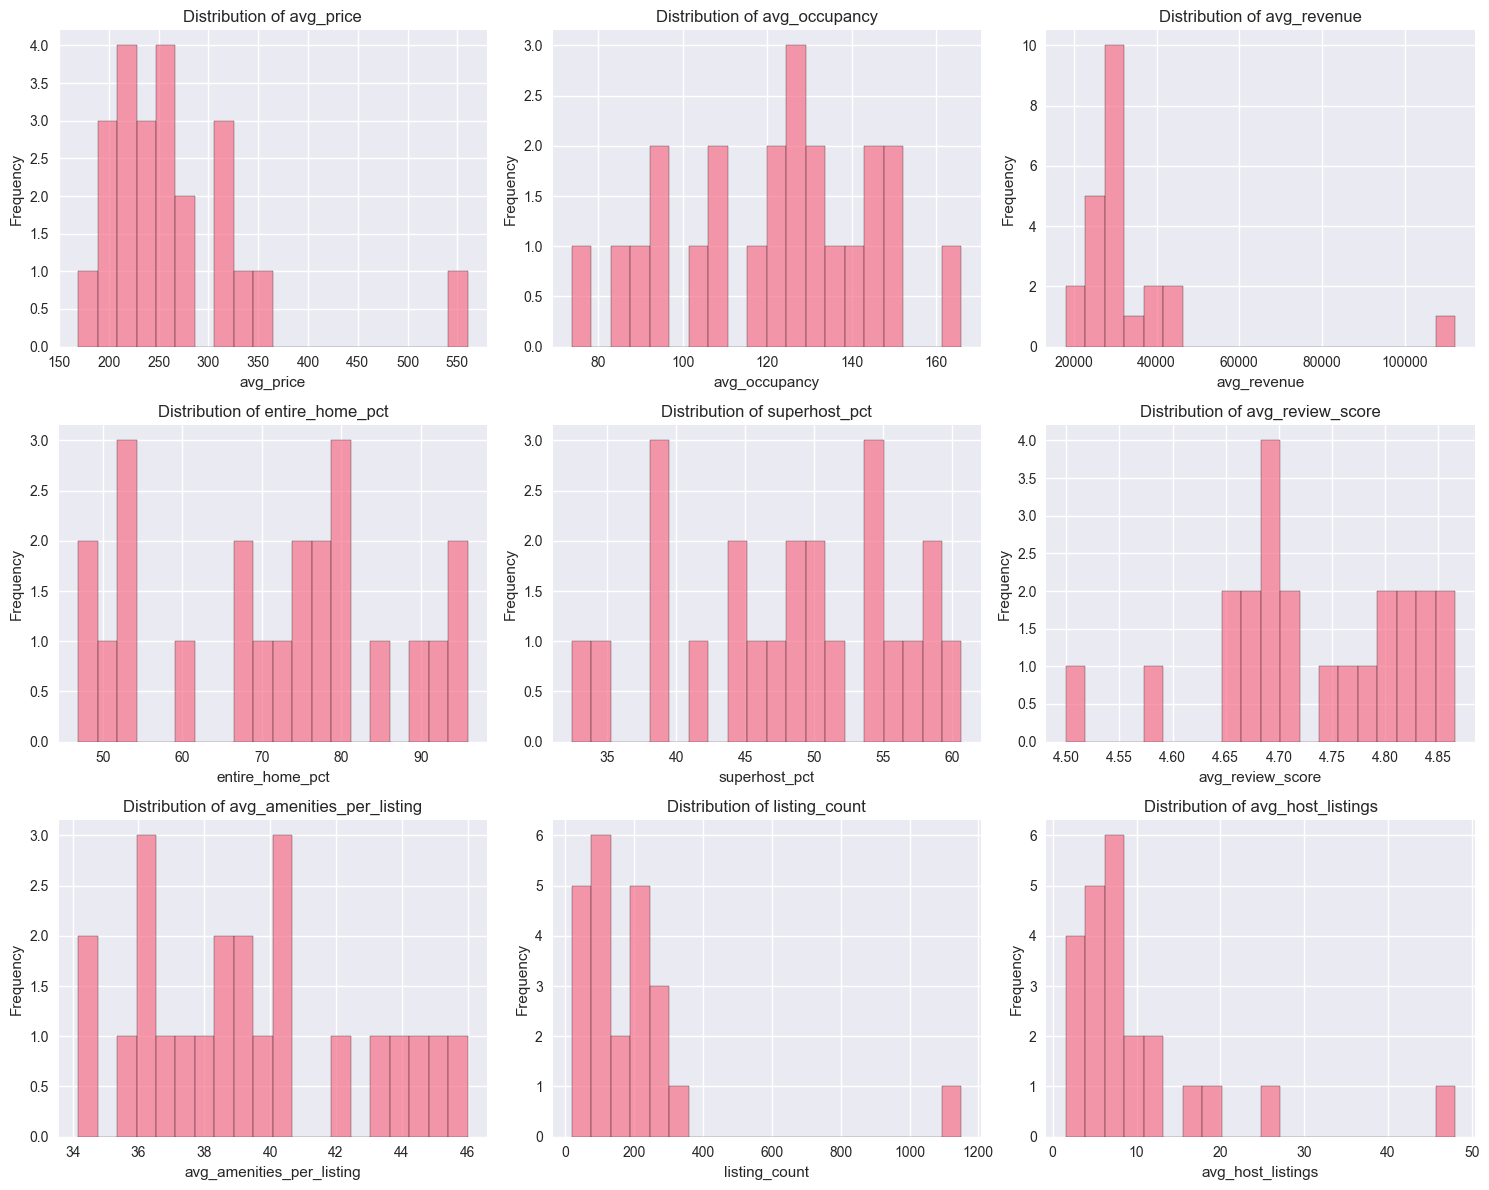

In [12]:
# Visualize feature distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(clustering_features):
    axes[i].hist(X[feature], bins=20, alpha=0.7, edgecolor='black')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Determining Optimal Number of Clusters

We'll use multiple methods to determine the optimal number of clusters:
1. **Elbow Method**: Plotting within-cluster sum of squares (WCSS) vs number of clusters
2. **Silhouette Analysis**: Measuring how similar an object is to its own cluster vs other clusters
3. **Davies-Bouldin Index**: Lower values indicate better clustering


In [13]:
# Elbow Method for optimal K
wcss = []
silhouette_scores = []
davies_bouldin_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    
    # Calculate Davies-Bouldin score
    db_score = davies_bouldin_score(X_scaled, kmeans.labels_)
    davies_bouldin_scores.append(db_score)

print("Clustering metrics calculated for K = 2 to 10")


Clustering metrics calculated for K = 2 to 10


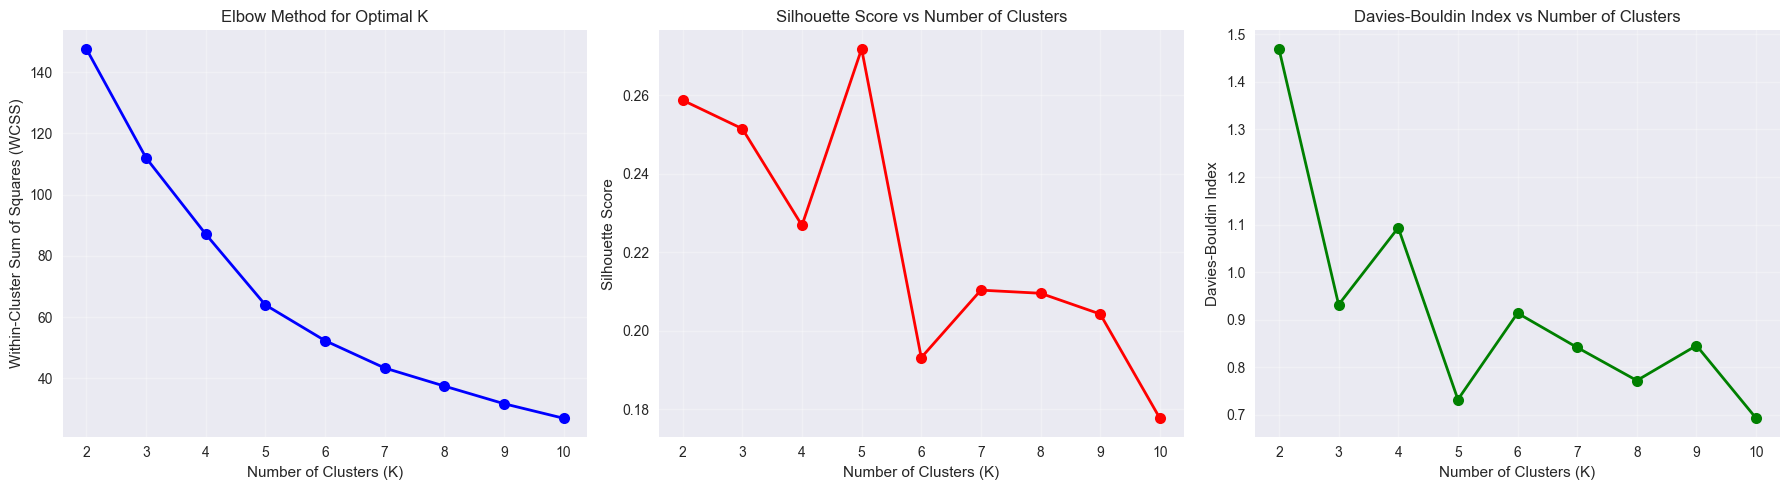

Optimal K based on Silhouette Score: 5
Optimal K based on Davies-Bouldin Index: 10
Silhouette scores: {2: 0.25877633421563095, 3: 0.2515142785852018, 4: 0.22688099973943918, 5: 0.2718577150475101, 6: 0.19320099688387254, 7: 0.21039033847098232, 8: 0.20959363861781435, 9: 0.20430156371805044, 10: 0.17775063748356593}
Davies-Bouldin scores: {2: 1.469310208880521, 3: 0.9318347936006219, 4: 1.0935462629986423, 5: 0.7324903605701574, 6: 0.9141003534251877, 7: 0.8418792733505965, 8: 0.7724706568420654, 9: 0.8459495628918168, 10: 0.6931608552728151}


In [14]:
# Plot clustering evaluation metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Elbow Method
axes[0].plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Within-Cluster Sum of Squares (WCSS)')
axes[0].set_title('Elbow Method for Optimal K')
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].grid(True, alpha=0.3)

# Davies-Bouldin Index
axes[2].plot(k_range, davies_bouldin_scores, 'go-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (K)')
axes[2].set_ylabel('Davies-Bouldin Index')
axes[2].set_title('Davies-Bouldin Index vs Number of Clusters')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal K based on different criteria
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_db = k_range[np.argmin(davies_bouldin_scores)]

print(f"Optimal K based on Silhouette Score: {optimal_k_silhouette}")
print(f"Optimal K based on Davies-Bouldin Index: {optimal_k_db}")
print(f"Silhouette scores: {dict(zip(k_range, silhouette_scores))}")
print(f"Davies-Bouldin scores: {dict(zip(k_range, davies_bouldin_scores))}")


## Implementing Clustering Algorithms

Based on the evaluation metrics, we'll implement three clustering algorithms:
1. **K-Means Clustering** (with optimal K)
2. **DBSCAN Clustering** (density-based)
3. **Hierarchical Clustering** (agglomerative)


In [15]:
# Choose optimal K (using silhouette score as primary criterion)
optimal_k = optimal_k_silhouette
print(f"Using K = {optimal_k} for clustering algorithms")

# 1. K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# 2. DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=3)
dbscan_labels = dbscan.fit_predict(X_scaled)

# 3. Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k)
hierarchical_labels = hierarchical.fit_predict(X_scaled)

print("All clustering algorithms implemented successfully!")
print(f"K-Means clusters: {len(set(kmeans_labels))}")
print(f"DBSCAN clusters: {len(set(dbscan_labels))} (including noise: {sum(dbscan_labels == -1)} noise points)")
print(f"Hierarchical clusters: {len(set(hierarchical_labels))}")


Using K = 5 for clustering algorithms
All clustering algorithms implemented successfully!
K-Means clusters: 5
DBSCAN clusters: 1 (including noise: 23 noise points)
Hierarchical clusters: 5


In [17]:
# Evaluate clustering performance
def evaluate_clustering(X, labels, algorithm_name):
    """Evaluate clustering performance using multiple metrics"""
    if len(set(labels)) < 2:  # Need at least 2 clusters for evaluation
        return {
            'algorithm': algorithm_name,
            'n_clusters': len(set(labels)),
            'silhouette_score': 0.0,
            'davies_bouldin_score': float('inf'),
            'n_noise_points': sum(labels == -1) if -1 in labels else 0
        }
    
    # Calculate metrics
    try:
        silhouette = silhouette_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
    except:
        silhouette = 0.0
        davies_bouldin = float('inf')
    
    # Count clusters (excluding noise for DBSCAN)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    return {
        'algorithm': algorithm_name,
        'n_clusters': n_clusters,
        'silhouette_score': silhouette,
        'davies_bouldin_score': davies_bouldin,
        'n_noise_points': sum(labels == -1) if -1 in labels else 0
    }

# Evaluate all algorithms
results = []
results.append(evaluate_clustering(X_scaled, kmeans_labels, 'K-Means'))
results.append(evaluate_clustering(X_scaled, dbscan_labels, 'DBSCAN'))
results.append(evaluate_clustering(X_scaled, hierarchical_labels, 'Hierarchical'))

# Filter out None results and create DataFrame
results = [r for r in results if r is not None]
results_df = pd.DataFrame(results)
print("Clustering Performance Comparison:")
print(results_df.round(4))


Clustering Performance Comparison:
      algorithm  n_clusters  silhouette_score  davies_bouldin_score  \
0       K-Means           5            0.2719                0.7325   
1        DBSCAN           1            0.0000                   inf   
2  Hierarchical           5            0.2660                0.7259   

   n_noise_points  
0               0  
1              23  
2               0  


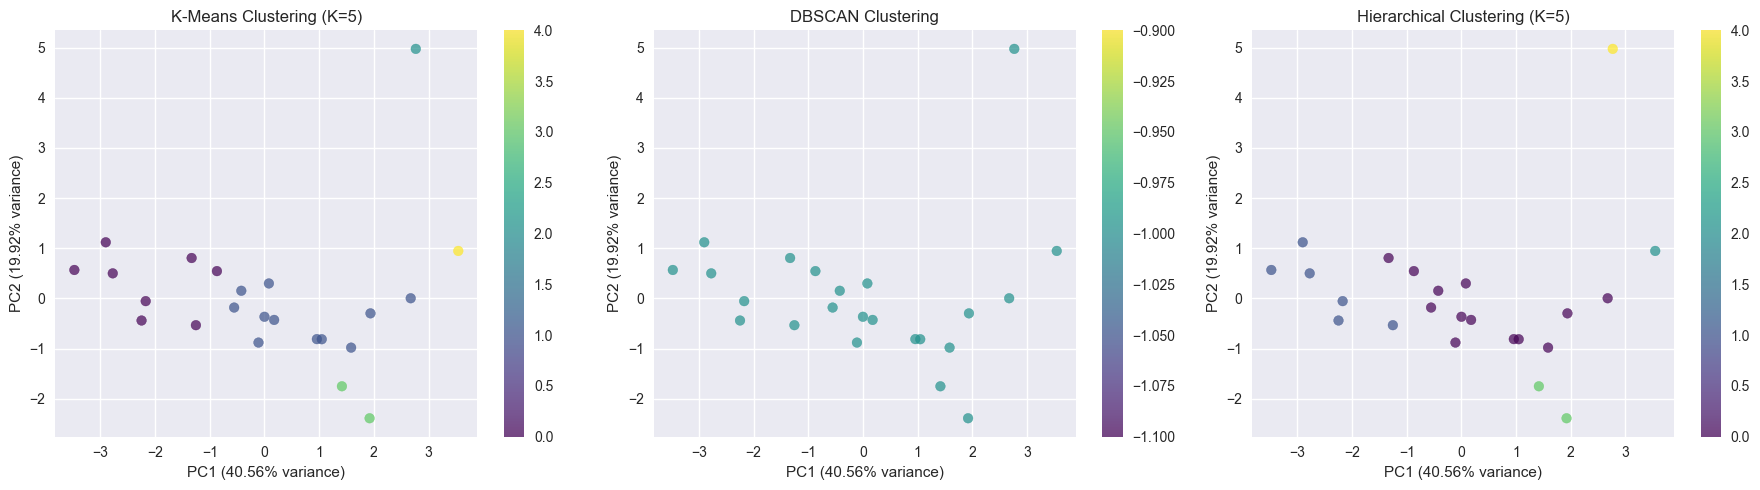

PCA explained variance ratio: [0.40558669 0.19924955]
Total variance explained by first 2 components: 60.48%


In [18]:
# Visualize clustering results using PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create subplots for different clustering results
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-Means
scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
axes[0].set_title(f'K-Means Clustering (K={optimal_k})')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter1, ax=axes[0])

# DBSCAN
scatter2 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
axes[1].set_title(f'DBSCAN Clustering')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter2, ax=axes[1])

# Hierarchical
scatter3 = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='viridis', alpha=0.7)
axes[2].set_title(f'Hierarchical Clustering (K={optimal_k})')
axes[2].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[2].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter3, ax=axes[2])

plt.tight_layout()
plt.show()

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained by first 2 components: {sum(pca.explained_variance_ratio_):.2%}")


In [19]:
# Add cluster labels to neighborhood data
neighborhood_df_clustered = neighborhood_df.copy()
neighborhood_df_clustered['kmeans_cluster'] = kmeans_labels
neighborhood_df_clustered['dbscan_cluster'] = dbscan_labels
neighborhood_df_clustered['hierarchical_cluster'] = hierarchical_labels

# Select the best performing algorithm (highest silhouette score)
best_algorithm_idx = results_df['silhouette_score'].idxmax()
best_algorithm = results_df.iloc[best_algorithm_idx]['algorithm']

if best_algorithm == 'K-Means':
    best_labels = kmeans_labels
elif best_algorithm == 'DBSCAN':
    best_labels = dbscan_labels
else:
    best_labels = hierarchical_labels

neighborhood_df_clustered['best_cluster'] = best_labels

print(f"Best performing algorithm: {best_algorithm}")
print(f"Silhouette score: {results_df.iloc[best_algorithm_idx]['silhouette_score']:.4f}")
print(f"Davies-Bouldin score: {results_df.iloc[best_algorithm_idx]['davies_bouldin_score']:.4f}")


Best performing algorithm: K-Means
Silhouette score: 0.2719
Davies-Bouldin score: 0.7325


In [20]:
# Load GeoJSON data for mapping
with open('../data/neighbourhoods.geojson', 'r') as f:
    geojson_data = json.load(f)

print("GeoJSON data loaded successfully!")
print(f"Number of neighborhoods in GeoJSON: {len(geojson_data['features'])}")

# Create a mapping from neighborhood names to cluster labels
neighborhood_to_cluster = dict(zip(neighborhood_df_clustered['neighborhood'], 
                                 neighborhood_df_clustered['best_cluster']))

# Add cluster information to GeoJSON features
for feature in geojson_data['features']:
    neighborhood_name = feature['properties']['neighbourhood']
    if neighborhood_name in neighborhood_to_cluster:
        feature['properties']['cluster'] = int(neighborhood_to_cluster[neighborhood_name])
        feature['properties']['avg_price'] = float(neighborhood_df_clustered[
            neighborhood_df_clustered['neighborhood'] == neighborhood_name]['avg_price'].iloc[0])
        feature['properties']['avg_revenue'] = float(neighborhood_df_clustered[
            neighborhood_df_clustered['neighborhood'] == neighborhood_name]['avg_revenue'].iloc[0])
    else:
        feature['properties']['cluster'] = -1  # No data available
        feature['properties']['avg_price'] = 0
        feature['properties']['avg_revenue'] = 0

print("Cluster information added to GeoJSON features")


GeoJSON data loaded successfully!
Number of neighborhoods in GeoJSON: 24
Cluster information added to GeoJSON features


Interactive map failed: Mime type rendering requires nbformat>=4.2.0 but it is not installed
Creating static scatter plot instead...


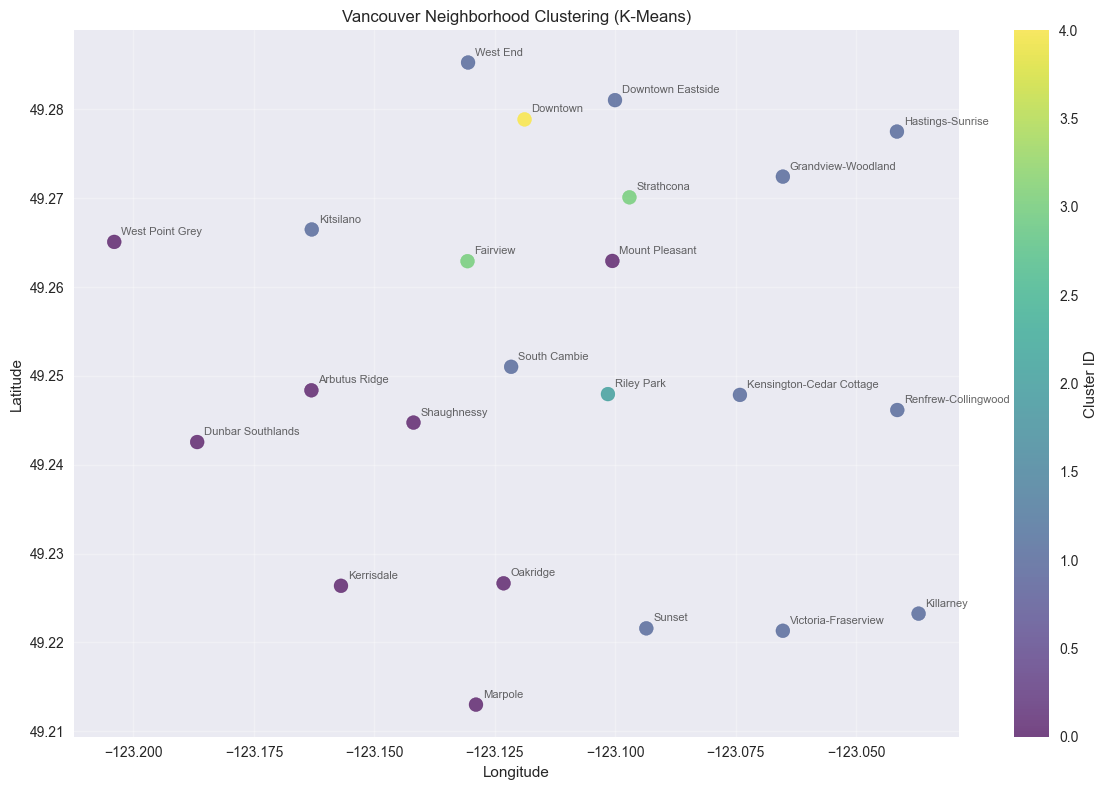

Static map created successfully!


In [22]:
# Create interactive map visualization
try:
    # Try to create interactive map
    fig = px.choropleth_mapbox(
        neighborhood_df_clustered,
        geojson=geojson_data,
        locations='neighborhood',
        featureidkey='properties.neighbourhood',
        color='best_cluster',
        color_continuous_scale='viridis',
        mapbox_style='open-street-map',
        zoom=10,
        center={'lat': 49.2827, 'lon': -123.1207},  # Vancouver coordinates
        opacity=0.7,
        title=f'Vancouver Neighborhood Clustering ({best_algorithm})',
        labels={'best_cluster': 'Cluster ID', 'avg_price': 'Average Price', 'avg_revenue': 'Average Revenue'}
    )

    # Add hover information
    fig.update_traces(
        hovertemplate='<b>%{location}</b><br>' +
                      'Cluster: %{z}<br>' +
                      'Avg Price: $%{customdata[0]:.0f}<br>' +
                      'Avg Revenue: $%{customdata[1]:.0f}<extra></extra>',
        customdata=neighborhood_df_clustered[['avg_price', 'avg_revenue']].values
    )

    fig.update_layout(
        height=600,
        margin={'r': 0, 't': 30, 'l': 0, 'b': 0}
    )

    # Try to show the plot
    fig.show()
    
except Exception as e:
    print(f"Interactive map failed: {e}")
    print("Creating static scatter plot instead...")
    
    # Create static scatter plot as alternative
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(neighborhood_df_clustered['longitude'], 
                         neighborhood_df_clustered['latitude'],
                         c=neighborhood_df_clustered['best_cluster'], 
                         cmap='viridis', alpha=0.7, s=100)
    
    plt.colorbar(scatter, label='Cluster ID')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Vancouver Neighborhood Clustering ({best_algorithm})')
    plt.grid(True, alpha=0.3)
    
    # Add neighborhood labels
    for idx, row in neighborhood_df_clustered.iterrows():
        plt.annotate(row['neighborhood'], 
                    (row['longitude'], row['latitude']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    
    print("Static map created successfully!")


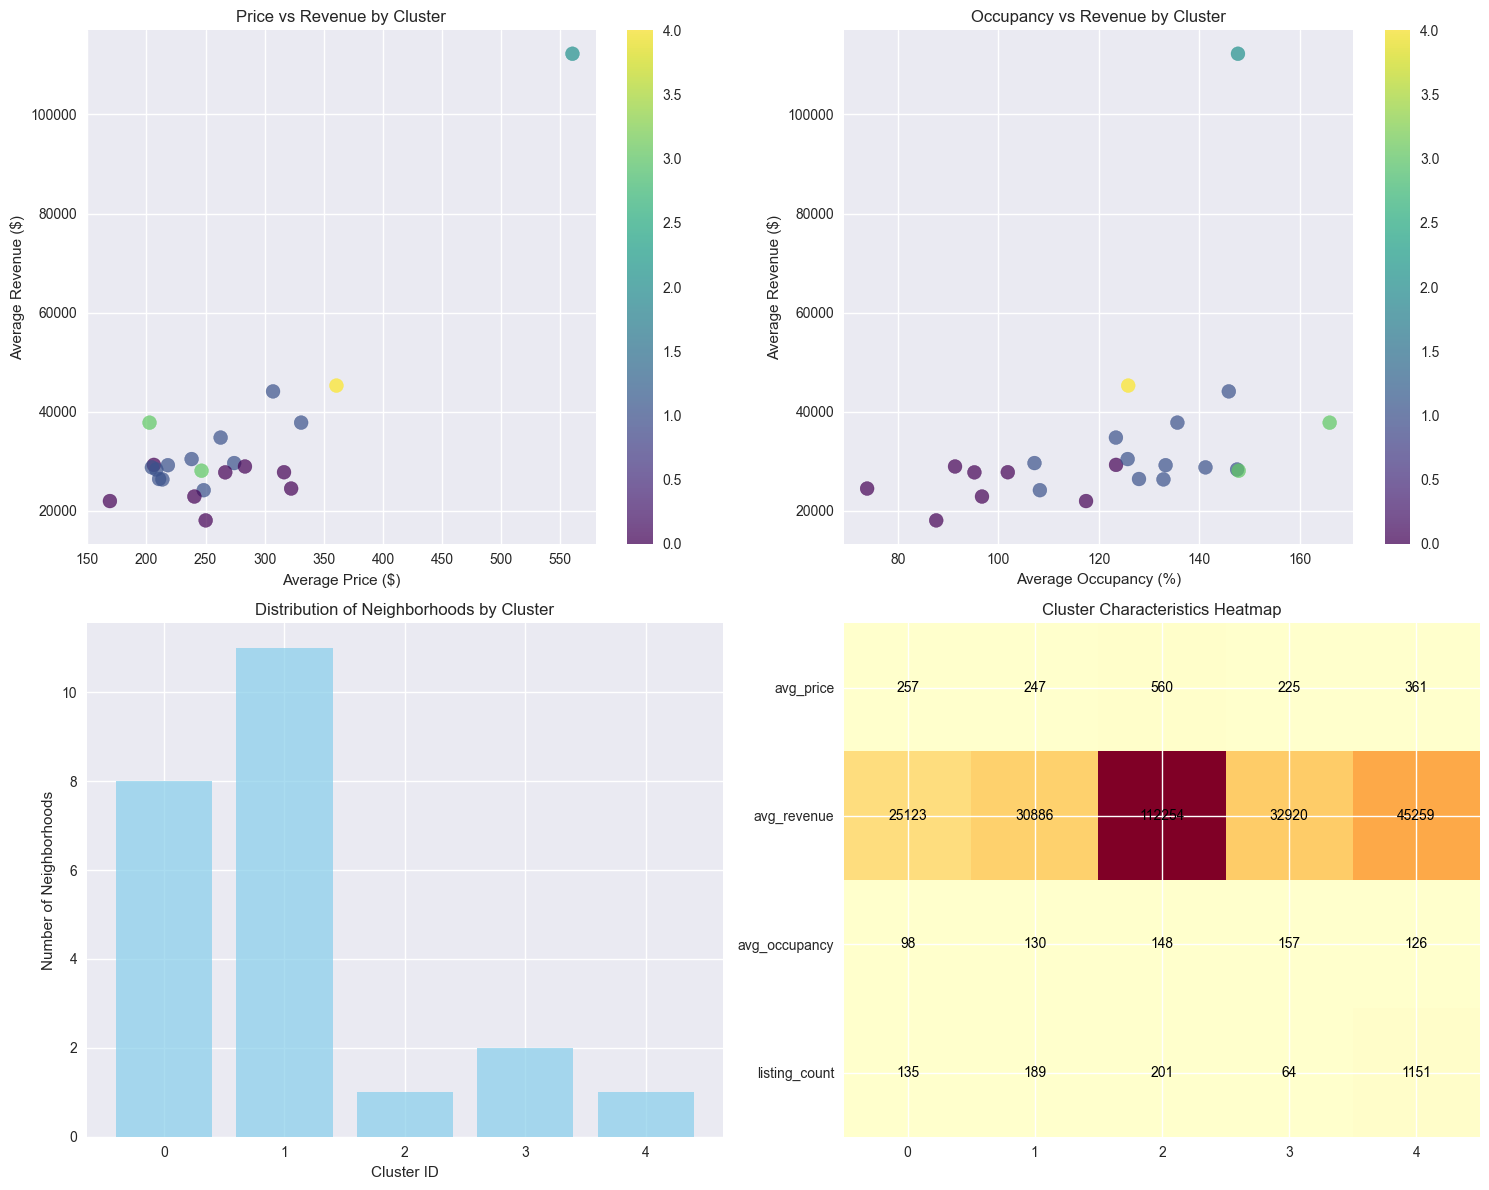

Cluster Statistics:
              avg_price  avg_revenue  avg_occupancy  listing_count
best_cluster                                                      
0                256.79     25122.90          98.43         134.75
1                246.93     30886.27         129.90         189.27
2                560.22    112254.29         147.69         201.00
3                224.57     32920.21         156.89          63.50
4                360.64     45259.00         125.84        1151.00


In [23]:
# Create additional visualizations for cluster analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Price vs Revenue scatter plot colored by cluster
scatter = axes[0, 0].scatter(neighborhood_df_clustered['avg_price'], 
                           neighborhood_df_clustered['avg_revenue'],
                           c=neighborhood_df_clustered['best_cluster'], 
                           cmap='viridis', alpha=0.7, s=100)
axes[0, 0].set_xlabel('Average Price ($)')
axes[0, 0].set_ylabel('Average Revenue ($)')
axes[0, 0].set_title('Price vs Revenue by Cluster')
plt.colorbar(scatter, ax=axes[0, 0])

# 2. Occupancy vs Revenue scatter plot
scatter2 = axes[0, 1].scatter(neighborhood_df_clustered['avg_occupancy'], 
                            neighborhood_df_clustered['avg_revenue'],
                            c=neighborhood_df_clustered['best_cluster'], 
                            cmap='viridis', alpha=0.7, s=100)
axes[0, 1].set_xlabel('Average Occupancy (%)')
axes[0, 1].set_ylabel('Average Revenue ($)')
axes[0, 1].set_title('Occupancy vs Revenue by Cluster')
plt.colorbar(scatter2, ax=axes[0, 1])

# 3. Cluster distribution
cluster_counts = neighborhood_df_clustered['best_cluster'].value_counts().sort_index()
axes[1, 0].bar(cluster_counts.index, cluster_counts.values, color='skyblue', alpha=0.7)
axes[1, 0].set_xlabel('Cluster ID')
axes[1, 0].set_ylabel('Number of Neighborhoods')
axes[1, 0].set_title('Distribution of Neighborhoods by Cluster')
axes[1, 0].set_xticks(cluster_counts.index)

# 4. Average metrics by cluster
cluster_stats = neighborhood_df_clustered.groupby('best_cluster').agg({
    'avg_price': 'mean',
    'avg_revenue': 'mean',
    'avg_occupancy': 'mean',
    'listing_count': 'mean'
}).round(2)

# Create a heatmap of cluster characteristics
im = axes[1, 1].imshow(cluster_stats.T.values, cmap='YlOrRd', aspect='auto')
axes[1, 1].set_xticks(range(len(cluster_stats.index)))
axes[1, 1].set_xticklabels(cluster_stats.index)
axes[1, 1].set_yticks(range(len(cluster_stats.columns)))
axes[1, 1].set_yticklabels(cluster_stats.columns)
axes[1, 1].set_title('Cluster Characteristics Heatmap')

# Add text annotations to heatmap
for i in range(len(cluster_stats.columns)):
    for j in range(len(cluster_stats.index)):
        text = axes[1, 1].text(j, i, f'{cluster_stats.iloc[j, i]:.0f}',
                              ha="center", va="center", color="black", fontsize=10)

plt.tight_layout()
plt.show()

print("Cluster Statistics:")
print(cluster_stats)


## Cluster Interpretation and Business Insights

Let's analyze the characteristics of each cluster to understand the market segments:


In [24]:
# Detailed cluster analysis
def analyze_cluster(cluster_id, df):
    """Analyze characteristics of a specific cluster"""
    cluster_data = df[df['best_cluster'] == cluster_id]
    
    analysis = {
        'cluster_id': cluster_id,
        'neighborhood_count': len(cluster_data),
        'neighborhoods': list(cluster_data['neighborhood']),
        'avg_price': cluster_data['avg_price'].mean(),
        'median_price': cluster_data['avg_price'].median(),
        'avg_revenue': cluster_data['avg_revenue'].mean(),
        'avg_occupancy': cluster_data['avg_occupancy'].mean(),
        'avg_listing_count': cluster_data['listing_count'].mean(),
        'entire_home_pct': cluster_data['entire_home_pct'].mean(),
        'superhost_pct': cluster_data['superhost_pct'].mean(),
        'avg_review_score': cluster_data['avg_review_score'].mean(),
        'avg_amenities': cluster_data['avg_amenities_per_listing'].mean()
    }
    
    return analysis

# Analyze each cluster
cluster_analyses = []
for cluster_id in sorted(neighborhood_df_clustered['best_cluster'].unique()):
    analysis = analyze_cluster(cluster_id, neighborhood_df_clustered)
    cluster_analyses.append(analysis)

# Create DataFrame for easy viewing
cluster_summary = pd.DataFrame(cluster_analyses)
cluster_summary = cluster_summary.round(2)

print("Detailed Cluster Analysis:")
print(cluster_summary)


Detailed Cluster Analysis:
   cluster_id  neighborhood_count  \
0           0                   8   
1           1                  11   
2           2                   1   
3           3                   2   
4           4                   1   

                                       neighborhoods  avg_price  median_price  \
0  [Mount Pleasant, Arbutus Ridge, Dunbar Southla...     256.79        258.32   
1  [Grandview-Woodland, West End, Kensington-Ceda...     246.93        238.16   
2                                       [Riley Park]     560.22        560.22   
3                             [Fairview, Strathcona]     224.57        224.57   
4                                         [Downtown]     360.64        360.64   

   avg_revenue  avg_occupancy  avg_listing_count  entire_home_pct  \
0     25122.90          98.43             134.75            54.07   
1     30886.27         129.90             189.27            79.50   
2    112254.29         147.69             201.00        

In [25]:
# Create cluster profiles with business insights
def create_cluster_profile(analysis):
    """Create a business profile for each cluster"""
    cluster_id = analysis['cluster_id']
    
    # Determine cluster characteristics
    if analysis['avg_price'] > cluster_summary['avg_price'].quantile(0.75):
        price_tier = "Premium"
    elif analysis['avg_price'] > cluster_summary['avg_price'].quantile(0.25):
        price_tier = "Mid-range"
    else:
        price_tier = "Budget"
    
    if analysis['avg_occupancy'] > cluster_summary['avg_occupancy'].quantile(0.75):
        demand_level = "High Demand"
    elif analysis['avg_occupancy'] > cluster_summary['avg_occupancy'].quantile(0.25):
        demand_level = "Medium Demand"
    else:
        demand_level = "Low Demand"
    
    if analysis['entire_home_pct'] > 70:
        property_type = "Entire Home Dominant"
    elif analysis['entire_home_pct'] < 30:
        property_type = "Shared Space Dominant"
    else:
        property_type = "Mixed Property Types"
    
    profile = {
        'Cluster ID': cluster_id,
        'Market Segment': f"{price_tier} - {demand_level}",
        'Property Focus': property_type,
        'Neighborhoods': len(analysis['neighborhoods']),
        'Avg Price': f"${analysis['avg_price']:.0f}",
        'Avg Revenue': f"${analysis['avg_revenue']:.0f}",
        'Occupancy Rate': f"{analysis['avg_occupancy']:.1f}%",
        'Superhost Rate': f"{analysis['superhost_pct']:.1f}%",
        'Review Score': f"{analysis['avg_review_score']:.2f}",
        'Key Neighborhoods': ', '.join(analysis['neighborhoods'][:3]) + ('...' if len(analysis['neighborhoods']) > 3 else '')
    }
    
    return profile

# Create profiles for all clusters
profiles = []
for analysis in cluster_analyses:
    profile = create_cluster_profile(analysis)
    profiles.append(profile)

profiles_df = pd.DataFrame(profiles)
print("Cluster Business Profiles:")
print(profiles_df.to_string(index=False))


Cluster Business Profiles:
 Cluster ID            Market Segment       Property Focus  Neighborhoods Avg Price Avg Revenue Occupancy Rate Superhost Rate Review Score                                         Key Neighborhoods
          0    Mid-range - Low Demand Mixed Property Types              8      $257      $25123          98.4%          41.4%         4.66       Mount Pleasant, Arbutus Ridge, Dunbar Southlands...
          1 Mid-range - Medium Demand Entire Home Dominant             11      $247      $30886         129.9%          51.4%         4.79 Grandview-Woodland, West End, Kensington-Cedar Cottage...
          2   Premium - Medium Demand Entire Home Dominant              1      $560     $112254         147.7%          57.9%         4.67                                                Riley Park
          3      Budget - High Demand Entire Home Dominant              2      $225      $32920         156.9%          50.0%         4.71                                      Fairview,

## Business Recommendations Based on Cluster Analysis

### Investment Strategy Recommendations:

1. **Premium High-Demand Clusters**: Focus on entire home properties with high amenity counts
2. **Mid-Range Medium-Demand Clusters**: Target superhosts and properties with good review scores
3. **Budget Low-Demand Clusters**: Consider renovation opportunities and amenity improvements

### Market Entry Strategy:

- **New Hosts**: Start in mid-range clusters to build reputation
- **Experienced Hosts**: Target premium clusters for higher returns
- **Property Investors**: Focus on entire home dominant clusters

### Competitive Positioning:

- **Differentiation**: Focus on amenities and superhost status in competitive clusters
- **Pricing Strategy**: Use cluster-specific pricing benchmarks
- **Marketing**: Tailor messaging to cluster characteristics


In [26]:
# Save results for future use
results_to_save = {
    'neighborhood_clusters': neighborhood_df_clustered,
    'cluster_summary': cluster_summary,
    'profiles': profiles_df,
    'best_algorithm': best_algorithm,
    'optimal_k': optimal_k,
    'clustering_features': clustering_features,
    'scaler': scaler
}

# Save to pickle for future use
import pickle
with open('neighborhood_clustering_results.pkl', 'wb') as f:
    pickle.dump(results_to_save, f)

print("Results saved to 'neighborhood_clustering_results.pkl'")
print("\nSummary:")
print(f"- Best clustering algorithm: {best_algorithm}")
print(f"- Optimal number of clusters: {optimal_k}")
print(f"- Total neighborhoods analyzed: {len(neighborhood_df_clustered)}")
print(f"- Features used: {len(clustering_features)}")
print(f"- Silhouette score: {results_df.iloc[best_algorithm_idx]['silhouette_score']:.4f}")


Results saved to 'neighborhood_clustering_results.pkl'

Summary:
- Best clustering algorithm: K-Means
- Optimal number of clusters: 5
- Total neighborhoods analyzed: 23
- Features used: 9
- Silhouette score: 0.2719
